# 프로젝트 요약
- 사용 데이터셋: App_data
https://www.kaggle.com/datasets/shanan93/app-data?select=top_screens.csv&sort=votes

- 문제 정의: 데이터를 이용하여 멤버십에 가입하지 않을 것 같은 사용자를 분석하고 마케팅 방안을 도출한다.

- 타겟 설정: 'enrolled' (멤버십에 가입했는지 여부) - 이진 분류 모델

- baseline 모델: 최빈값

- 평가지표: roc_auc

- 교차검증을 이용해 하이퍼 파라미터를 튜닝하여 모델의 일반화와 최적화 도모

- 최종 모델: CatBoost + 임계값 재설정

- Test Score: 0.779

- SHAP을 활용하여 모델 작동을 설명하고 가설 해소와 문제 해결을 진행

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# !pip install

In [2]:
!pip install category_encoders
!pip install catboost
!pip install eli5

     |████████████████████████████████| 80 kB 3.9 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 216 kB 5.0 MB/s 
     |████████████████████████████████| 133 kB 38.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=f0d57a2c1dd8ec5143580786e19046670b88ff71730ed346c7e9c3acc19cbb70
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.

# 데이터 불러오기

In [3]:
import pandas as pd

directory = '/content/drive/MyDrive/Colab Notebooks/project/project2/'
df = pd.read_csv(directory + 'appdata10.csv')
df_top = pd.read_csv(directory + 'top_screens.csv')

train = df[df['first_open'] <= '2013-06-30']
test = df[df['first_open'] > '2013-06-30']

In [4]:
train.shape,test.shape

((47256, 12), (2744, 12))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  50000 non-null  int64 
 1   first_open            50000 non-null  object
 2   dayofweek             50000 non-null  int64 
 3   hour                  50000 non-null  object
 4   age                   50000 non-null  int64 
 5   screen_list           50000 non-null  object
 6   numscreens            50000 non-null  int64 
 7   minigame              50000 non-null  int64 
 8   used_premium_feature  50000 non-null  int64 
 9   enrolled              50000 non-null  int64 
 10  enrolled_date         31074 non-null  object
 11  liked                 50000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


- **user**: 유저마다 주어진 고유값
- **first_open**: 어플리케이션에 첫 번째로 로그인한 날짜와 시간
- **dayofweek**: 로그인한 요일
- **hour**: 로그인한 시간
- **screen_list**: 유저가 본 스크린들의 이름
- **age**: 등록한 유저의 나이
- **minigame**: 유저가 어플리케이션에서 제공한 미니게임을 했는지 여부
- **used_premium_feature**: 유저가 프리미엄 상품을 이용했는지 여부
- **enrolled**: 유저가 멤버십에 가입했는지 여부
- **enrolled date**: 유저가 멤버십에 가입한 날짜
- **liked**: 유저가 어플리케이션 좋아요 버튼을 눌렀는지 여부
- **numscreens**: 유저가 본 스크린의 총 개수

In [6]:
df.describe()

user     dayofweek          age    numscreens      minigame  \
count   50000.000000  50000.000000  50000.00000  50000.000000  50000.000000   
mean   186889.729900      3.029860     31.72436     21.095900      0.107820   
std    107768.520361      2.031997     10.80331     15.728812      0.310156   
min        13.000000      0.000000     16.00000      1.000000      0.000000   
25%     93526.750000      1.000000     24.00000     10.000000      0.000000   
50%    187193.500000      3.000000     29.00000     18.000000      0.000000   
75%    279984.250000      5.000000     37.00000     28.000000      0.000000   
max    373662.000000      6.000000    101.00000    325.000000      1.000000   

       used_premium_feature      enrolled         liked  
count          50000.000000  50000.000000  50000.000000  
mean               0.172020      0.621480      0.165000  
std                0.377402      0.485023      0.371184  
min                0.000000      0.000000      0.000000  
25%                0.000000      0.000000      0.000000  
50%                0.000000      1.000000      0.000000  
75%                0.000000      1.000000      0.000000  
max                1.000000      1.000000      1.000000

In [7]:
df.head()

user               first_open  dayofweek       hour  age  \
0  235136  2012-12-27 02:14:51.273          3   02:00:00   23   
1  333588  2012-12-02 01:16:00.905          6   01:00:00   24   
2  254414  2013-03-19 19:19:09.157          1   19:00:00   23   
3  234192  2013-07-05 16:08:46.354          4   16:00:00   28   
4   51549  2013-02-26 18:50:48.661          1   18:00:00   31   

                                         screen_list  numscreens  minigame  \
0  idscreen,joinscreen,Cycle,product_review,ScanP...          15         0   
1  joinscreen,product_review,product_review2,Scan...          13         0   
2                                  Splash,Cycle,Loan           3         0   
3  product_review,Home,product_review,Loan3,Finan...          40         0   
4  idscreen,joinscreen,Cycle,Credit3Container,Sca...          32         0   

   used_premium_feature  enrolled            enrolled_date  liked  
0                     0         0                      NaN      0  
1                     0         0                      NaN      0  
2                     1         0                      NaN      1  
3                     0         1  2013-07-05 16:11:49.513      0  
4                     0         1  2013-02-26 18:56:37.841      1

In [8]:
df[df['numscreens']<5][df['screen_list'].str.split(',').apply(len) != df['numscreens']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


user               first_open  dayofweek       hour  age  \
202     67270  2013-01-26 16:26:40.792          5   16:00:00   23   
306     85455  2013-03-27 18:35:40.679          2   18:00:00   29   
308    186933  2013-05-23 12:24:35.773          3   12:00:00   53   
406    167899  2013-04-27 03:59:54.385          5   03:00:00   21   
451    227752  2012-12-07 08:46:56.479          4   08:00:00   27   
...       ...                      ...        ...        ...  ...   
49298   27080  2013-07-01 00:08:03.592          0   00:00:00   31   
49405  171160  2013-03-03 14:21:15.791          6   14:00:00   36   
49598  209036  2013-03-01 14:41:49.516          4   14:00:00   41   
49645  318062  2013-03-21 14:51:33.895          3   14:00:00   42   
49824  259497  2013-04-27 19:13:42.141          5   19:00:00   23   

                               screen_list  numscreens  minigame  \
202                      Loan2,ProfilePage           3         0   
306     Home,Loan2,WelcomeBankVerification           4         0   
308                      Splash,Home,Loan2           4         0   
406    Cycle,VerifyPhone,VerifyDateOfBirth           4         0   
451                            ProfilePage           2         0   
...                                    ...         ...       ...   
49298   product_review,Home,product_review           4         0   
49405                         Loan1,Payoff           3         0   
49598                  Home,product_review           4         0   
49645                      Home,Loan2,Loan           4         0   
49824                           Loan2,Loan           3         0   

       used_premium_feature  enrolled            enrolled_date  liked  
202                       0         0                      NaN      0  
306                       0         0                      NaN      0  
308                       0         0                      NaN      1  
406                       0         0                      NaN      0  
451                       0         0                      NaN      0  
...                     ...       ...                      ...    ...  
49298                     0         0                      NaN      0  
49405                     0         0                      NaN      0  
49598                     1         1  2013-05-12 19:22:01.319      0  
49645                     0         0                      NaN      1  
49824                     1         0                      NaN      1  

[511 rows x 12 columns]

# EDA

In [9]:
# EDA

def eda_process(data, train=0, cols=[]):
    
    # 날짜 변수 삭제
    data.drop(['first_open', 'enrolled_date'], axis=1, inplace=True)

    data['hour'] = data['hour'].str[:3].apply(int)

    # screen_list -> list
    data['screen_list'] = data['screen_list'].str.split(',')

    # screen_list와 numscreen의 차이 여부를 나타내는 컬럼 추가
    data['unknown_screen'] = (data['numscreens'] != data['screen_list'].apply(len))

    # Saving1, Saving2, Saving3, ... -> Saving
    screen_list = list(df_top['top_screens'].sort_values())

    for value in ['CC', 'Credit', 'Loan', 'Saving', 'product_review']:
        for li in data['screen_list']:
            for i, l in enumerate(li):
                if value in l:
                    li[i] = value
        for i, v in enumerate(screen_list):
            if value in v:
                screen_list[i] = value

    screen_list = sorted(list(set(screen_list)))
    data['screen_list'] = data['screen_list'].apply(lambda x: list(set(x)))

    # screen_list -> columns
    for col in screen_list:
        data[col] = data['screen_list'].apply(lambda x: 1 if col in x else 0)

    # age_bin
    data['age_bin'] = pd.cut(df['age'], bins=[15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 105],
                             labels=[1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6])

    # drop
    data.drop(['user', 'screen_list', 'screen_list', 'age', 'minigame'], axis=1, inplace=True)

    # feature 수 줄이기 위해 접속 빈도가 낮은 screen drop
    if train == 1:
        cols = []
        for col in screen_list:
            if data[col].mean() < 0.1:
                cols.append(col)
        data.drop(cols, axis=1, inplace=True)
        return cols, data
    else:
        data.drop(cols, axis=1, inplace=True)
        return data

In [10]:
cols, train_processed = eda_process(train.copy(), train=1)
test_processed = eda_process(test.copy(), cols=cols)

In [11]:
train_processed.shape, test_processed.shape

((47256, 20), (2744, 20))

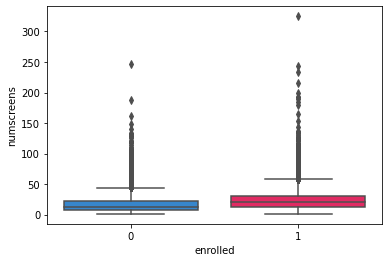

In [12]:
import seaborn as sns
colors = ['#1E88E5', '#FF0D57']
sns.set_palette(sns.color_palette(colors))

sns.boxplot(x='enrolled', y='numscreens', data=train_processed)

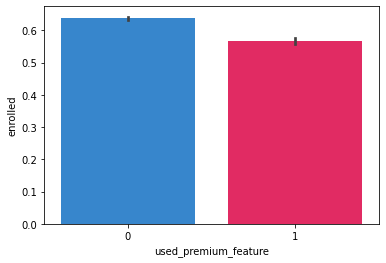

In [13]:
import seaborn as sns
sns.barplot(x='used_premium_feature', y='enrolled', data=train_processed)

# X, y 데이터 분리

In [14]:
target = 'enrolled'

def divide_data(data):
    
    X = data.drop(target, axis=1)
    y = data[target]   

    return X, y

In [15]:
X_train, y_train = divide_data(train_processed)
X_test, y_test = divide_data(test_processed)

# 기준모델 - 최빈값

In [16]:
y_train.mode()[0]

1

In [17]:
from sklearn.metrics import roc_auc_score
predict = y_train.mode()[0]

y_train_pred = [predict] * len(y_train)
baseline_train_score = roc_auc_score(y_train, y_train_pred)

print(f'train 기준모델 점수: {baseline_train_score:.2f}')

train 기준모델 점수: 0.50


In [18]:
from sklearn.metrics import roc_auc_score
y_test_pred = [predict] * len(y_test)
baseline_test_score = roc_auc_score(y_test, y_test_pred)

print(f'test 기준모델 점수: {baseline_test_score:.2f}')

test 기준모델 점수: 0.50


In [19]:
from sklearn.metrics import accuracy_score

baseline_train_score = accuracy_score(y_train, y_train_pred)
print(f'train 기준모델 점수: {baseline_train_score:.2f}')

baseline_test_score = accuracy_score(y_test, y_test_pred)
print(f'test 기준모델 점수: {baseline_test_score:.2f}')

train 기준모델 점수: 0.63
test 기준모델 점수: 0.55


# 모델링

## XGBClassifier

In [20]:
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

def XGB_fit(X_train, y_train):
    
    pipeline = make_pipeline(
        TargetEncoder(),
        XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.1, early_stopping=50) 
        ) 

    dists = {
        'xgbclassifier__n_estimators': randint(50, 500),
        'xgbclassifier__max_depth': range(3,12),
        'xgbclassifier__colsample_bytree': uniform(0.6, 0.9),
        'xgbclassifier__colsample_bylevel': uniform(0.6, 0.9)
    }

    clf = RandomizedSearchCV(
        pipeline, 
        param_distributions=dists, 
        n_iter=50, 
        cv=5, 
        scoring='roc_auc',  
        verbose=1,
        n_jobs=-1
    )    

    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf

XGB_clf = XGB_fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
205 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/train

Optimal Hyperparameter: {'xgbclassifier__colsample_bylevel': 0.8776439709129216, 'xgbclassifier__colsample_bytree': 0.8866030799284286, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 112}
AUC: 0.8155450400899771


## RandomForest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

def RF_fit(X_train, y_train):
    
    pipeline = make_pipeline(
        TargetEncoder(),
        RandomForestClassifier(
        n_jobs=-1, random_state=42, oob_score=True) 
        ) 

    dists = {
        'randomforestclassifier__min_samples_split': range(5,10), 
        'randomforestclassifier__n_estimators': randint(50, 500), 
        'randomforestclassifier__max_depth': range(3,12), 
        'randomforestclassifier__max_features': uniform(0, 1)
    }

    clf = RandomizedSearchCV(
        pipeline, 
        param_distributions=dists, 
        n_iter=50, 
        cv=5, 
        scoring='roc_auc',  
        verbose=1,
        n_jobs=-1
    )    

    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)
    
    return clf

RF_clf = RF_fit(X_train, y_train)

print("Optimal Hyperparameter:", RF_clf.best_params_)
print("AUC:", RF_clf.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimal Hyperparameter: {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 0.32004848977745937, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 358}
AUC: 0.8150809740959634
Optimal Hyperparameter: {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__max_features': 0.32004848977745937, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 358}
AUC: 0.8150809740959634


## CatBoost

In [22]:
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

def Cat_fit(X_train, y_train):
    
    pipeline = make_pipeline(
        TargetEncoder(),
        CatBoostClassifier(random_state=42, learning_rate=0.1) 
        ) 

    dists = {
        'catboostclassifier__n_estimators': randint(50, 500), 
        'catboostclassifier__depth': range(3,12)
    }

    clf = RandomizedSearchCV(
        pipeline, 
        param_distributions=dists, 
        n_iter=50, 
        cv=5, 
        scoring='roc_auc',  
        verbose=1,
        n_jobs=-1
    )    
    
    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)
    
    return clf

Cat_clf = Cat_fit(X_train, y_train)

print("Optimal Hyperparameter:", Cat_clf.best_params_)
print("AUC:", Cat_clf.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0:	learn: 0.6683965	total: 58.3ms	remaining: 9.57s
1:	learn: 0.6477552	total: 68.2ms	remaining: 5.55s
2:	learn: 0.6288629	total: 76.2ms	remaining: 4.12s
3:	learn: 0.6136694	total: 84.2ms	remaining: 3.39s
4:	learn: 0.5999298	total: 92.9ms	remaining: 2.97s
5:	learn: 0.5904378	total: 102ms	remaining: 2.69s
6:	learn: 0.5809102	total: 110ms	remaining: 2.48s
7:	learn: 0.5722193	total: 118ms	remaining: 2.32s
8:	learn: 0.5650138	total: 127ms	remaining: 2.19s
9:	learn: 0.5591446	total: 135ms	remaining: 2.09s
10:	learn: 0.5536683	total: 143ms	remaining: 2s
11:	learn: 0.5486541	total: 151ms	remaining: 1.92s
12:	learn: 0.5441883	total: 159ms	remaining: 1.86s
13:	learn: 0.5408641	total: 168ms	remaining: 1.81s
14:	learn: 0.5375440	total: 176ms	remaining: 1.76s
15:	learn: 0.5346948	total: 184ms	remaining: 1.72s
16:	learn: 0.5322617	total: 193ms	remaining: 1.68s
17:	learn: 0.5300119	total: 201ms	remaining: 1.64s
18:	learn: 0.5283526	total: 

# Best Model 및 임계값 재설정 및 최종 성능

In [23]:
pipeline = Cat_clf.best_estimator_

preprocess_pipline = pipeline.named_steps['targetencoder']
model = pipeline.named_steps['catboostclassifier']

X_test_preprocessed = preprocess_pipline.transform(X_test)

In [24]:
from sklearn.metrics import roc_curve

y_train_proba = pipeline.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

In [25]:
import numpy as np
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 6163 , threshold: 0.6188575922184106


Text(0, 0.5, 'TPR(Recall)')

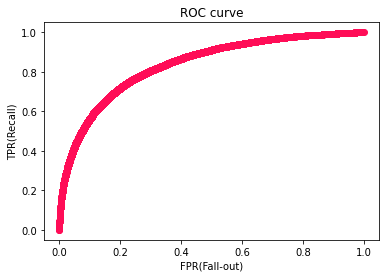

In [26]:
import matplotlib.pyplot as plt

plt.scatter(fpr, tpr, color='#FF0D57')
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

In [27]:
y_pred_optimal = y_train_proba >= optimal_threshold

In [28]:
auc_score = roc_auc_score(y_train, y_pred_optimal)
auc_score

0.7599789234110133

In [29]:
y_test_proba = pipeline.predict_proba(X_test)[:, 1]
y_test_optimal = y_test_proba >= optimal_threshold
auc_score = roc_auc_score(y_test, y_test_optimal)
print(f'최종 모델 성능: {auc_score}')

최종 모델 성능: 0.7800964769037295


In [30]:
from sklearn.metrics import accuracy_score

baseline_train_score = accuracy_score(y_train,y_pred_optimal)
print(f'train 기준모델 점수: {baseline_train_score:.2f}')

baseline_test_score = accuracy_score(y_test, y_test_optimal)
print(f'test 기준모델 점수: {baseline_test_score:.2f}')

train 기준모델 점수: 0.76
test 기준모델 점수: 0.78


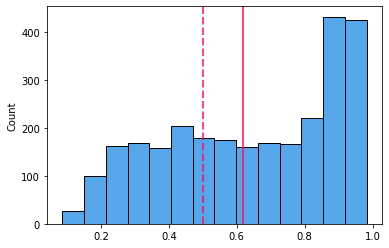

In [31]:
colors = ['#1E88E5', '#FF0D57']
sns.set_palette(sns.color_palette(colors))

ax = sns.histplot(y_test_proba)
ax.axvline(0.5, linestyle=(0, (5,2)), color='#FF0D57')
ax.axvline(optimal_threshold, color='#FF0D57')

# PI

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

def get_permutation_importance(X, y, model):

    permuter = PermutationImportance(
        model,
        scoring='roc_auc',
        n_iter=5,
        random_state=42
    )
    
    permuter.fit(X, y)

    return permuter

In [33]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
print("Top3 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i)

Top3 Important Features:
[('VerifyPhone', 0.1514591930583822), ('numscreens', 0.10768511740525928), ('Credit', 0.02281735082681082), ('VerifyDateOfBirth', 0.018683538058502914), ('BankVerification', 0.01396657362195961), ('unknown_screen', 0.011825633682720226), ('Loan', 0.010863975073671605), ('VerifyCountry', 0.010709150826274572), ('location', 0.007891263718731523), ('age_bin', 0.006798216330284634), ('ProfilePage', 0.005783412300671231), ('used_premium_feature', 0.005468990907360194), ('idscreen', 0.002931524994704238), ('dayofweek', 0.0008260332118657842), ('hour', 0.0006635937780709922), ('Splash', 4.011379877140175e-05), ('liked', 1.0725614644768733e-05), ('Institutions', -5.041038883026872e-05), ('Cycle', -0.00022298552846438112)]


# SHAP

In [34]:
!pip install shap

     |████████████████████████████████| 564 kB 5.1 MB/s 


In [35]:
import shap

X_test_preprocessed_dt = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_preprocessed_dt[:100])

shap.initjs()
shap_values = explainer.shap_values(X_test_preprocessed_dt.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test_preprocessed_dt.iloc[:100], link='logit')

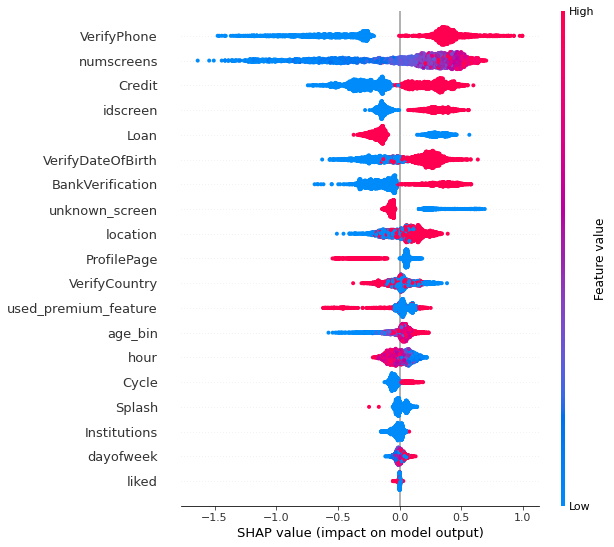

In [36]:
shap_values = explainer.shap_values(X_test_preprocessed_dt)
shap.summary_plot(shap_values, X_test_preprocessed_dt)

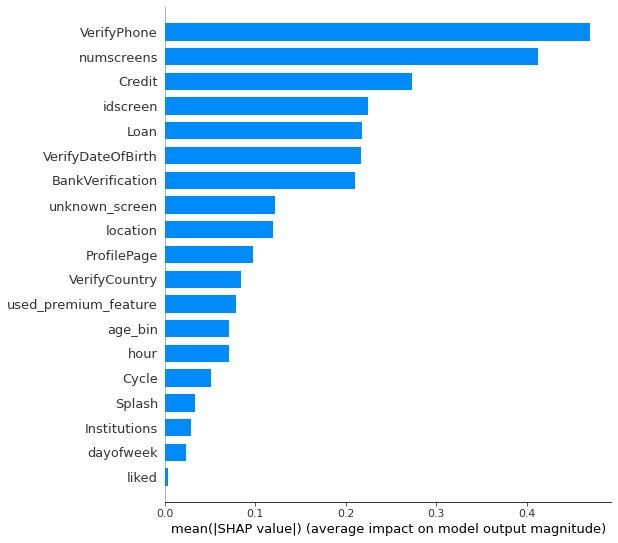

In [37]:
shap.summary_plot(shap_values, X_test_preprocessed_dt, plot_type="bar")

In [39]:
X_test_preprocessed_dt0 = X_test_preprocessed_dt.copy()
X_test_preprocessed_dt0['y_proba'] = pipeline.predict_proba(X_test)[:, 1]
X_test_preprocessed_dt0['y_test'] = y_test
X_test_preprocessed_dt0[X_test_preprocessed_dt0['y_proba'] < 0.1]

dayofweek  hour  numscreens  used_premium_feature  liked  \
23897          3    23          21                     1      1   
37507          1    23          14                     1      0   

       unknown_screen  BankVerification  Credit  Cycle  Institutions  ...  \
23897            True                 0       1      0             0  ...   
37507            True                 0       1      0             0  ...   

       ProfilePage  Splash  VerifyCountry  VerifyDateOfBirth  VerifyPhone  \
23897            1       0              0                  0            0   
37507            1       0              0                  0            0   

       idscreen  location   age_bin   y_proba  y_test  
23897         0         0  0.571652  0.090447       0  
37507         0         0  0.571652  0.086623       0  

[2 rows x 21 columns]

In [40]:
X_test_preprocessed_dt = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_preprocessed_dt.loc[[23897]])

shap.initjs()
shap_values = explainer.shap_values(X_test_preprocessed_dt.loc[[23897]])
shap.force_plot(explainer.expected_value, shap_values, X_test_preprocessed_dt.loc[[23897]], link='logit')

In [41]:
X_test_preprocessed_dt = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_preprocessed_dt.loc[[37507]])

shap.initjs()
shap_values = explainer.shap_values(X_test_preprocessed_dt.loc[[37507]])
shap.force_plot(explainer.expected_value, shap_values, X_test_preprocessed_dt.loc[[37507]], link='logit')